<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/alpaca_execution_adapter_LightGBM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpaca-trade-api
!pip install python-dotenv
!pip install ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.5 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp311-cp311-linux_x86_64.whl size=15688 sha256=ec154ed2621d3a12f6ca5f80d0b496dfcfa176f6412435fdaecf5d9d7cf4e6a1
  Stored in directory: /root/.cache/pip/wheels/f6/35/da/ed9b26b510235e00e3a3c3bab7bad97b59214729662255ab3d
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.1
    Uninstalling msgpack-1.1.1:
      Successfully uninstalled msgpack-1.1.1
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling 

In [2]:
import csv
import time
import pickle
import warnings
import pandas as pd
import lightgbm as lgb
import ta
from datetime import datetime, timedelta
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame, APIError

warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
RESULTS_DIR = "/content/drive/MyDrive/Alpaca_Results/LightGBM"
os.makedirs(RESULTS_DIR, exist_ok=True)


Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()  # Prompts you to upload the .env file for


Saving Alpaca_keys.env.txt to Alpaca_keys.env.txt


In [5]:
# Rename to .env so dotenv can recognize it
os.rename("Alpaca_keys.env.txt", ".env")


In [6]:
from google.colab import files
uploaded = files.upload()  # Upload: model_ABT.txt, features_ABT.txt, scaler_ABT.pkl

import lightgbm as lgb
import pickle

print("Model, features, and scaler loaded for ABT.")


Saving features_ABT.txt to features_ABT.txt
Saving features_BRK.B.txt to features_BRK.B.txt
Saving features_MDT.txt to features_MDT.txt
Saving features_PG.txt to features_PG.txt
Saving features_PM.txt to features_PM.txt
Saving model_ABT.txt to model_ABT.txt
Saving model_BRK.B.txt to model_BRK.B.txt
Saving model_MDT.txt to model_MDT.txt
Saving model_PG.txt to model_PG.txt
Saving model_PM.txt to model_PM.txt
Saving scaler_ABT.pkl to scaler_ABT.pkl
Saving scaler_BRK.B.pkl to scaler_BRK.B.pkl
Saving scaler_MDT.pkl to scaler_MDT.pkl
Saving scaler_PG.pkl to scaler_PG.pkl
Saving scaler_PM.pkl to scaler_PM.pkl
Model, features, and scaler loaded for ABT.


In [7]:

#Load .env credentials
load_dotenv(override=True)
API_KEY = os.getenv("APCA_API_KEY_ID")
SECRET_KEY = os.getenv("APCA_API_SECRET_KEY")
BASE_URL = "https://paper-api.alpaca.markets"  # or live URL

#Create API object
api = REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

#Check account
account = api.get_account()
print("Account status:", account.status)

Account status: ACTIVE


In [8]:
#Connect to Alpaca
api = REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')
account = api.get_account()
print("Connected to Alpaca:", account.status)

Connected to Alpaca: ACTIVE


In [9]:
COOLDOWN_MINUTES = 60  # Minimum time in minutes between trades for same ticker
def load_model_artifacts(ticker):
    model = lgb.Booster(model_file=f'model_{ticker}.txt')
    with open(f'features_{ticker}.txt', 'r') as f:
        features = f.read().strip().split(',')
    with open(f'scaler_{ticker}.pkl', 'rb') as f:
        scaler = pickle.load(f)
    return model, features, scaler

def add_features(df):
    df = df.copy()
    df['SMA_50'] = ta.trend.sma_indicator(df['close'], window=50)
    df['EMA_20'] = ta.trend.ema_indicator(df['close'], window=20)

    volatility = df['close'].rolling(14).std()

    rsi = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    macd_diff = ta.trend.macd_diff(df['close'])
    signal_line = ta.trend.macd_signal(df['close'])
    atr = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    obv = ta.volume.on_balance_volume(df['close'], df['volume'])
    cci = ta.trend.cci(df['high'], df['low'], df['close'], window=20)

    df['RSI_voladj'] = rsi * volatility
    df['MACD_voladj'] = macd_diff * volatility
    df['Signal_Line'] = signal_line
    df['ATR_voladj'] = atr * volatility
    df['OBV'] = obv
    df['CCI_voladj'] = cci * volatility

    return df.dropna()

def log_trade(ticker, signal, action, price, equity, position_qty):
    now = datetime.utcnow().isoformat()
    row = {
        "datetime": now,
        "ticker": ticker,
        "signal": signal,
        "action": action,
        "price": float(price),
        "equity": float(equity),
        "position_qty": float(position_qty)
    }
    log_file = os.path.join(RESULTS_DIR, f"trade_log_{ticker}.csv")
    file_exists = os.path.isfile(log_file)
    with open(log_file, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)
    print(f"Logged trade to Drive: {log_file}")

In [10]:
tickers = ["ABT", "BRK.B", "PM", "PG", "MDT"]

for ticker in tickers:
    print(f"\nRunning strategy for {ticker}...")

    try:
        model, model_features, scaler = load_model_artifacts(ticker)
        print(f"Model artifacts loaded for {ticker}")
    except Exception as e:
        print(f"Could not load model for {ticker}: {e}")
        continue

    try:
        end = datetime.utcnow().replace(microsecond=0).isoformat() + "Z"
        start = (datetime.utcnow() - timedelta(days=45)).replace(microsecond=0).isoformat() + "Z"
        bars = api.get_bars(ticker, TimeFrame.Hour, start=start, end=end, feed="iex").df
        bars = bars.reset_index()
        bars = add_features(bars)
        if len(bars) < 10:
            print(f"Not enough data after features for {ticker}")
            continue
    except Exception as e:
        print(f"Error fetching/processing bars for {ticker}: {e}")
        continue

    if not all(f in bars.columns for f in model_features):
        missing = [f for f in model_features if f not in bars.columns]
        print(f"Missing features for {ticker}: {missing}")
        continue

    # === Prediction ===
    X_live = bars[model_features].copy().dropna()
    X_scaled = scaler.transform(X_live)
    preds = model.predict(X_scaled)
    signal = int(preds[-1])
    print(f"Prediction for {ticker}: {signal} (1 = Buy, 0 = Sell)")

    # === Trade Execution ===
    price = bars.iloc[-1]["close"]
    try:
        history = api.get_portfolio_history(period="1D", timeframe="5Min")
        equity = history.equity[-1]
    except:
        equity = 0

    action = "Hold"
    position_qty = 0

    try:
        clock = api.get_clock()
        if not clock.is_open:
            print("Market is closed.")
            continue

        try:
            position = api.get_position(ticker)
            has_position = float(position.qty) > 0
            position_qty = float(position.qty)
        except APIError:
            has_position = False
            position_qty = 0
            print(f"No current position in {ticker}")

        # Bootstrap Logic
        if not has_position:
            try:
                log_file = os.path.join(RESULTS_DIR, f"trade_log_{ticker}.csv")
                needs_bootstrap = False

                if not os.path.exists(log_file):
                    needs_bootstrap = True
                else:
                    with open(log_file, "r") as f:
                        lines = f.readlines()
                        if len(lines) <= 1:
                            needs_bootstrap = True

                if needs_bootstrap:
                    api.submit_order(symbol=ticker, qty=1, side='buy', type='market', time_in_force='gtc')
                    action = "Initial_Buy"
                    print(f"Initial BUY submitted for {ticker}")

            except Exception as e:
                print(f"Could not bootstrap {ticker}: {e}")
        #Cooldown Logic
        cooldown_active = False
        log_file = os.path.join(RESULTS_DIR, f"trade_log_{ticker}.csv")

        if os.path.exists(log_file):
            try:
                df_log = pd.read_csv(log_file)
                df_log['datetime'] = pd.to_datetime(df_log['datetime'])
                last_trade_time = df_log['datetime'].max()
                minutes_since_last = (datetime.utcnow() - last_trade_time).total_seconds() / 60

                if minutes_since_last < COOLDOWN_MINUTES:
                    cooldown_active = True
                    print(f"Cooldown active for {ticker} ({minutes_since_last:.1f} mins ago)")
            except Exception as e:
                print(f"Error reading log for cooldown check: {e}")

        #Model-based Trade Decision
        if signal == 1 and not has_position and not cooldown_active:
            api.submit_order(symbol=ticker, qty=1, side='buy', type='market', time_in_force='gtc')
            action = "Buy"
            print(f"BUY order submitted for {ticker}")

        elif signal == 0 and has_position and not cooldown_active:
            api.submit_order(symbol=ticker, qty=1, side='sell', type='market', time_in_force='gtc')
            action = "Sell"
            print(f"SELL order submitted for {ticker}")

        else:
            print(f"No action taken for {ticker}")

    except Exception as e:
        print(f"Trade error for {ticker}: {e}")
        continue

    # === Logging ===
    log_trade(ticker, signal, action, price, equity, position_qty)

    # === Portfolio Snapshot ===
    print("Portfolio snapshot:")
    positions = api.list_positions()
    for p in positions:
        print(f"{p.symbol}: {p.qty} shares (${p.market_value})")

    print("Recent Equity:", history.equity[-3:])
    print(f"Strategy complete for {ticker}")


Running strategy for ABT...
Model artifacts loaded for ABT
Prediction for ABT: 0 (1 = Buy, 0 = Sell)
No current position in ABT
Initial BUY submitted for ABT
No action taken for ABT
Logged trade to Drive: /content/drive/MyDrive/Alpaca_Results/LightGBM/trade_log_ABT.csv
Portfolio snapshot:
AAPL: 2 shares ($422.51)
MDT: 1 shares ($88.715)
PG: 1 shares ($154.435)
PM: 1 shares ($178.89)
Recent Equity: [100009.68, 100009.15, 100009.14]
Strategy complete for ABT

Running strategy for BRK.B...
Model artifacts loaded for BRK.B
Prediction for BRK.B: 0 (1 = Buy, 0 = Sell)
No current position in BRK.B
Initial BUY submitted for BRK.B
No action taken for BRK.B
Logged trade to Drive: /content/drive/MyDrive/Alpaca_Results/LightGBM/trade_log_BRK.B.csv
Portfolio snapshot:
AAPL: 2 shares ($422.54)
ABT: 1 shares ($120.786)
MDT: 1 shares ($88.715)
PG: 1 shares ($154.435)
PM: 1 shares ($178.89)
Recent Equity: [100009.68, 100009.18, 100009.14]
Strategy complete for BRK.B

Running strategy for PM...
Model a

In [11]:
#Log Portfolio and Account Status
positions = api.list_positions()
for p in positions:
    print(f"{p.symbol}: {p.qty} shares (${p.market_value})")

history = api.get_portfolio_history(period="1D", timeframe="5Min")
print("Recent Equity:", history.equity[-5:])


print("Strategy complete. Await next live cycle.")


AAPL: 2 shares ($422.56)
ABT: 1 shares ($120.786)
BRK.B: 1 shares ($469.89)
MDT: 1 shares ($88.715)
Recent Equity: [100009.44, 100009.41, 100009.68, 100009.2, 100008.99]
Strategy complete. Await next live cycle.


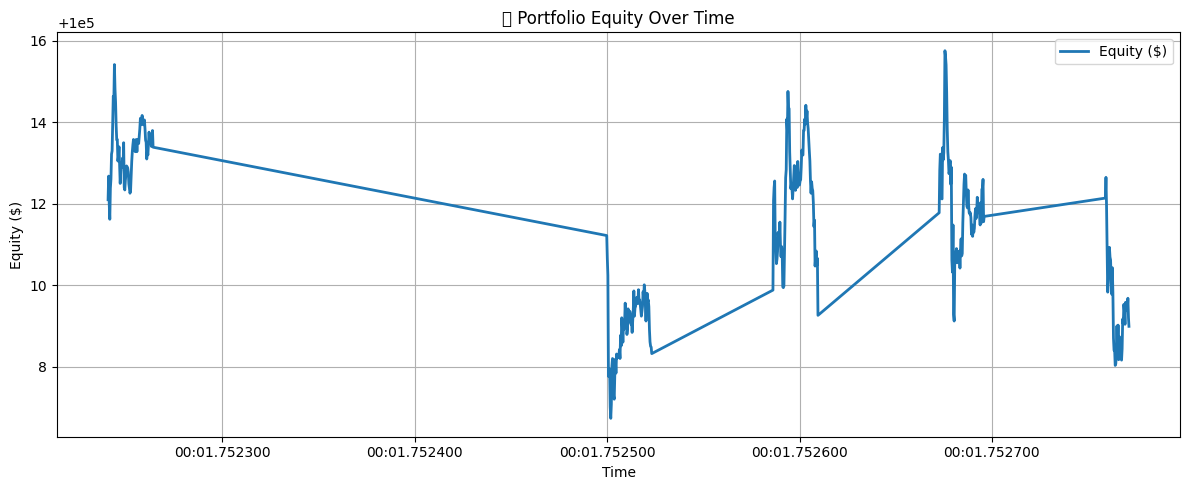

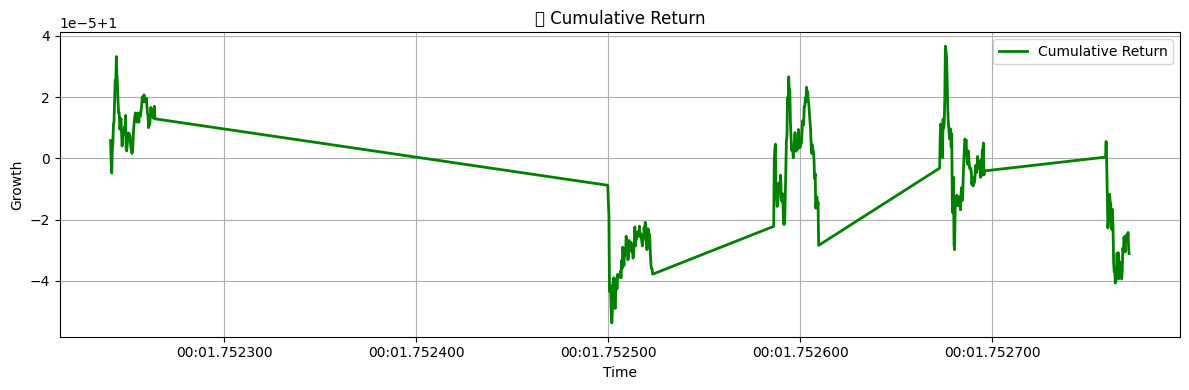

In [12]:
#Plot Portfolio Equity & Returns
import matplotlib.pyplot as plt

# Get full recent equity history (optional: extend period)
try:
    equity_history = api.get_portfolio_history(period="5D", timeframe="5Min")
    equity_series = pd.Series(equity_history.equity, index=pd.to_datetime(equity_history.timestamp))

    # Calculate returns
    returns = equity_series.pct_change().dropna()
    cumulative_return = (1 + returns).cumprod()

    # Plot equity
    plt.figure(figsize=(12, 5))
    plt.plot(equity_series, label="Equity ($)", linewidth=2)
    plt.title("Portfolio Equity Over Time")
    plt.xlabel("Time")
    plt.ylabel("Equity ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot cumulative return
    plt.figure(figsize=(12, 4))
    plt.plot(cumulative_return, label="Cumulative Return", color="green", linewidth=2)
    plt.title("Cumulative Return")
    plt.xlabel("Time")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Could not retrieve or plot equity history:", e)
